# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



# STEPIK ID: 652595808 (может тоже надо будет)
# CAGGLE ID: egorsid12
# Имя в команде: Егор_Сидоров_652595808

### Установка зависимостей

In [5]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
#
# if it prints otherwise, then you need to enable GPU:
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [2]:
import PIL
print(PIL.__version__)

11.0.0


In [3]:
!nvidia-smi
import torch
torch.cuda.is_available()

Thu Nov  7 22:17:55 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.80                 Driver Version: 546.80       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4060 ...  WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   53C    P8               4W / 100W |    381MiB /  8188MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

True

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [4]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision.transforms import v2 as transforms
from torchvision import models

from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [5]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation.

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample)

In [ ]:
#определим директории с тренировочными и тестовыми файлами (выполнял локально, а не в colab, поэтому свои пути к данным)
TRAIN_DIR = Path(fr'C:\projects\Python\dl\DataBases\SIMPSONS\train')
TEST_DIR = Path(fr'C:\projects\Python\dl\DataBases\SIMPSONS\testset')

In [7]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [8]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [9]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.Resize((224, 224)),  # вместо кастомного метода
            transforms.RandomHorizontalFlip(),  # Случайное горизонтальное отражение
            transforms.RandomRotation(30),      # Случайное вращение на 30 градусов
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Изменение яркости, контрастности и насыщенности
            transforms.ToImage(),
            transforms.ToDtype(torch.float32, scale=True),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = transform(x)
        x = x / 255  # вместо работы с numpy
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [10]:
val_dataset = SimpsonsDataset(val_files, mode='val')

In [11]:
val_dataset[0][0].data.shape

torch.Size([3, 224, 224])

In [12]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')

train_dataset = SimpsonsDataset(train_files, mode='train')

In [13]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [14]:
n_classes = len(np.unique(train_val_labels))

In [170]:
# uncomment if you have problem with pillow
# def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
# Image.register_extension = register_extension
# def register_extensions(id, extensions):
#     for extension in extensions: register_extension(id, extension)
# Image.register_extensions = register_extensions

Давайте посмотрим на наших героев внутри датасета.

In [41]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

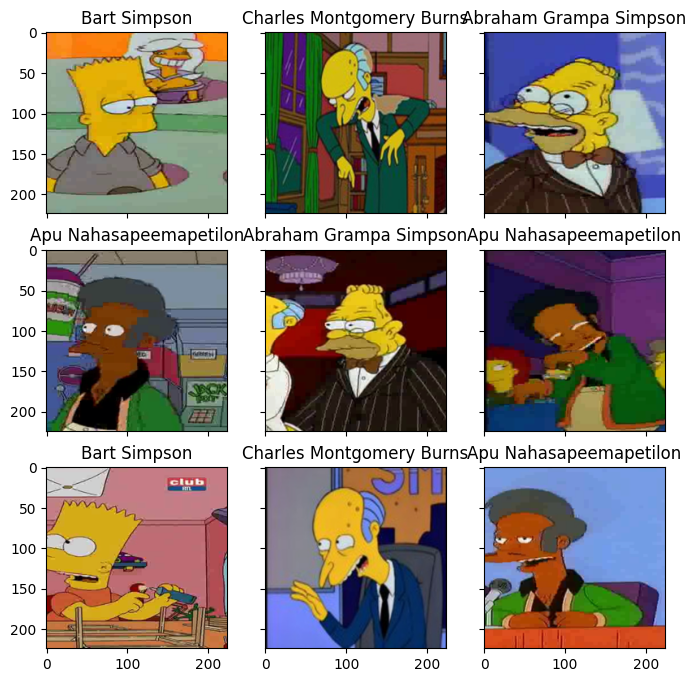

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [ ]:
# Очень простая сеть
class SimpleCnn(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.out = nn.Linear(96 * 5 * 5, n_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify: {} classes".format(n_classes))
print(simple_cnn)

we will classify: 42 classes
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=2400,

Запустим обучение сети.

Я использую свою библиотеку для обучения, написанную лично. Мне просто так удобнее. Ссылка на проект на гитхабе, если интересно - https://github.com/egrsid/torchlab

In [220]:
import sys
sys.path.append('C:\projects\Python')

from torchlab.training import Trainer
import torch.optim as optim

In [221]:
from torchlab.training import Trainer

In [54]:
trainer = Trainer(
    model=simple_cnn,
    criterion=nn.CrossEntropyLoss(),
    optimizer=optim.Adam(simple_cnn.parameters(), lr=3e-3),
    train_loader=train_loader,
    test_loader=val_loader,
    epochs=2,
    device=DEVICE
)

In [55]:
trainer.train_model()

Epoch 1/2 - Train Loss: 2.7126, Train Accuracy: 0.2400, Valid Loss: 2.0751, Valid Accuracy: 0.4440 - Time: 149.76s


Epoch 2/2 - Train Loss: 1.6634, Train Accuracy: 0.5469, Valid Loss: 1.3224, Valid Accuracy: 0.6504 - Time: 141.10s


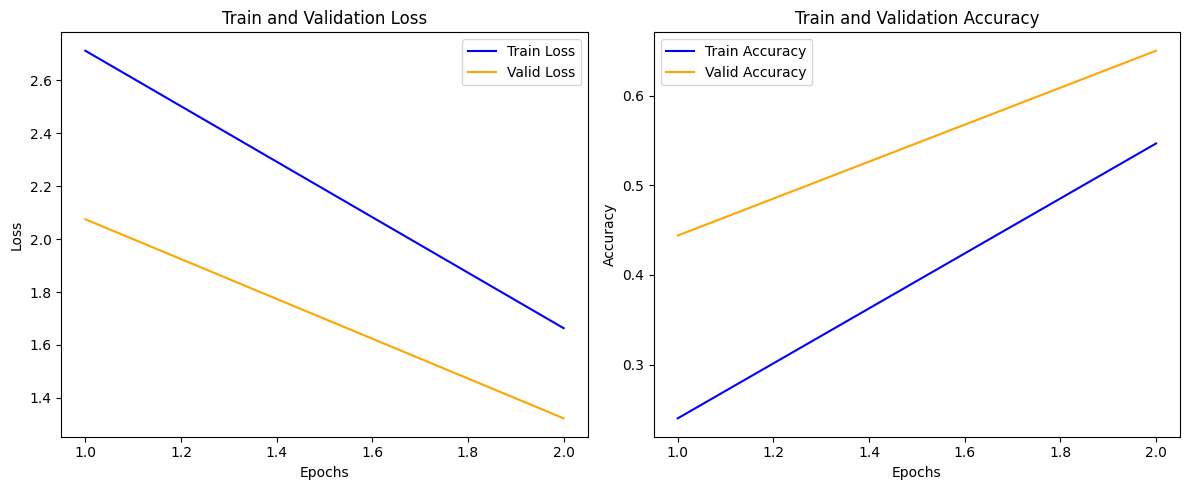

In [56]:
trainer.plot_metrics()

#### ResNet18

Замена и обучение только последнего слоя. Посмотрим на результат. Нейронка будет просто отправной точкой, чтобы понимать куда двигаться дальше

In [216]:
model_resnet18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

In [217]:
model_resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [218]:
in_features = 512
out_features = n_classes

for param in model_resnet18.parameters():
  param.requires_grad = False

model_resnet18.fc = nn.Linear(in_features, out_features)

optimizer = optim.Adam(model_resnet18.fc.parameters(), lr=3e-3)

In [224]:
trainer = Trainer(
    model = model_resnet18,
    criterion = nn.CrossEntropyLoss(),
    optimizer = optimizer,
    device = DEVICE,
    train_loader = train_loader,
    test_loader = val_loader,
    epochs = 30,
    patience=4,
    scheduler=optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.7)
)

In [225]:
trainer.train_model()

Epoch 1/30 - Train Loss: 2.2332, Train Accuracy: 0.4117, Valid Loss: 1.7797, Valid Accuracy: 0.5342 - Time: 268.88s


Epoch 2/30 - Train Loss: 1.6196, Train Accuracy: 0.5591, Valid Loss: 1.5966, Valid Accuracy: 0.5655 - Time: 274.53s


Epoch 3/30 - Train Loss: 1.4834, Train Accuracy: 0.5899, Valid Loss: 1.4808, Valid Accuracy: 0.5976 - Time: 260.86s


Epoch 4/30 - Train Loss: 1.3996, Train Accuracy: 0.6089, Valid Loss: 1.4553, Valid Accuracy: 0.6005 - Time: 271.24s


Epoch 5/30 - Train Loss: 1.3661, Train Accuracy: 0.6177, Valid Loss: 1.3874, Valid Accuracy: 0.6213 - Time: 258.90s


Epoch 6/30 - Train Loss: 1.3301, Train Accuracy: 0.6279, Valid Loss: 1.3753, Valid Accuracy: 0.6211 - Time: 257.06s


Epoch 7/30 - Train Loss: 1.3042, Train Accuracy: 0.6342, Valid Loss: 1.3617, Valid Accuracy: 0.6255 - Time: 257.28s


Epoch 8/30 - Train Loss: 1.2944, Train Accuracy: 0.6374, Valid Loss: 1.3709, Valid Accuracy: 0.6343 - Time: 259.39s


Epoch 9/30 - Train Loss: 1.2857, Train Accuracy: 0.6375, Valid Loss: 1.3678, Valid Accuracy: 0.6274 - Time: 257.24s


Epoch 10/30 - Train Loss: 1.2814, Train Accuracy: 0.6409, Valid Loss: 1.3760, Valid Accuracy: 0.6278 - Time: 258.50s


Epoch 11/30 - Train Loss: 1.2863, Train Accuracy: 0.6418, Valid Loss: 1.3314, Valid Accuracy: 0.6376 - Time: 257.81s


Epoch 12/30 - Train Loss: 1.2821, Train Accuracy: 0.6411, Valid Loss: 1.3807, Valid Accuracy: 0.6156 - Time: 260.90s


Epoch 13/30 - Train Loss: 1.2728, Train Accuracy: 0.6411, Valid Loss: 1.3854, Valid Accuracy: 0.6246 - Time: 260.40s


Epoch 14/30 - Train Loss: 1.2637, Train Accuracy: 0.6513, Valid Loss: 1.3599, Valid Accuracy: 0.6244 - Time: 261.86s



Early stopping triggered after 14 epochs


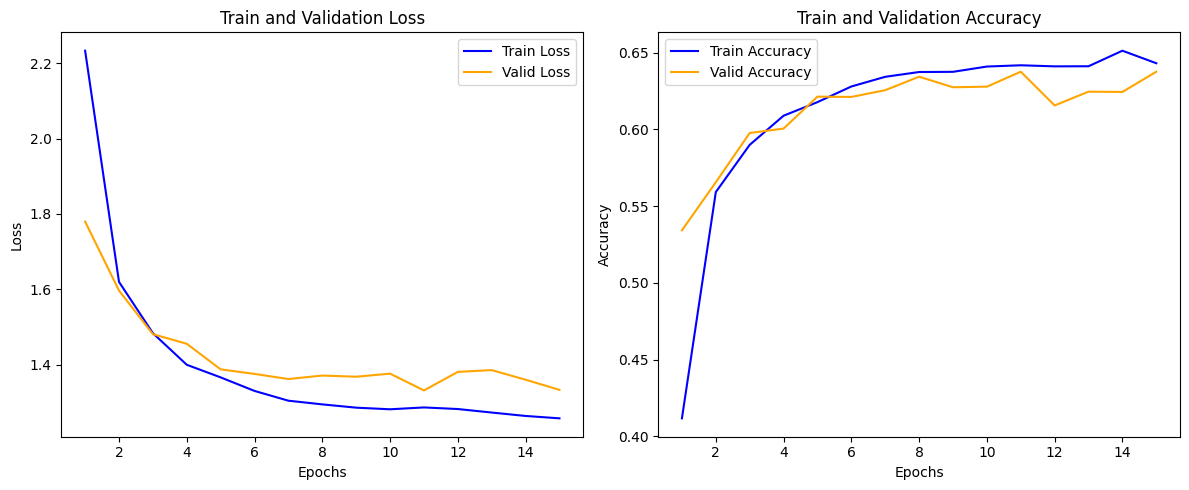

In [226]:
trainer.plot_metrics()

Точность не радует. Буду пробовать идти вглубь для улучшения результата

#### DenseNet

Обучение fc слоя и последних двух dense блоков. Размораживаю отталкиваясь от колиичества тринирумых параметров. Надо, чтобы было и не очень мало, и не очень много

In [ ]:
model_densenet = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)

In [ ]:
model_densenet

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
from itertools import chain

in_features = 1024
out_features = n_classes
layers_to_unfreeze = 4  # обучу 2 последних dense блока модели

for param in model_densenet.features[:-layers_to_unfreeze].parameters():
    param.requires_grad = False

model_densenet.classifier = nn.Linear(in_features, out_features)

optimizer = torch.optim.Adam(
    chain(
        list(model_densenet.features.parameters())[-layers_to_unfreeze:],
        model_densenet.classifier.parameters()
    ),
    lr=3e-2,
)

In [ ]:
import sys
sys.path.append('C:\projects\Python')

from torchlab.training import Trainer

In [ ]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')

train_dataset = SimpsonsDataset(train_files, mode='train')

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

In [ ]:
trainer = Trainer(
    model = model_densenet,
    criterion = nn.CrossEntropyLoss(),
    optimizer = optimizer,
    device = DEVICE,
    train_loader = train_loader,
    test_loader = val_loader,
    epochs = 20,
    scheduler=optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5)
)

In [ ]:
trainer.train_model()

Epoch 1/20 - Train Loss: 1.1924, Train Accuracy: 0.7103, Valid Loss: 0.8104, Valid Accuracy: 0.7896 - Time: 221.32s


Epoch 2/20 - Train Loss: 0.6231, Train Accuracy: 0.8337, Valid Loss: 0.8039, Valid Accuracy: 0.7826 - Time: 135.32s


Epoch 3/20 - Train Loss: 0.4761, Train Accuracy: 0.8726, Valid Loss: 0.7148, Valid Accuracy: 0.8101 - Time: 137.15s


Epoch 4/20 - Train Loss: 0.4094, Train Accuracy: 0.8915, Valid Loss: 0.6539, Valid Accuracy: 0.8248 - Time: 138.76s


Epoch 5/20 - Train Loss: 0.3724, Train Accuracy: 0.9035, Valid Loss: 0.6317, Valid Accuracy: 0.8342 - Time: 139.34s


Epoch 6/20 - Train Loss: 0.3506, Train Accuracy: 0.9114, Valid Loss: 0.6271, Valid Accuracy: 0.8353 - Time: 138.67s


Epoch 7/20 - Train Loss: 0.3415, Train Accuracy: 0.9143, Valid Loss: 0.6227, Valid Accuracy: 0.8393 - Time: 131.83s


Epoch 8/20 - Train Loss: 0.3378, Train Accuracy: 0.9145, Valid Loss: 0.6232, Valid Accuracy: 0.8384 - Time: 124.46s


Epoch 9/20 - Train Loss: 0.3330, Train Accuracy: 0.9177, Valid Loss: 0.6242, Valid Accuracy: 0.8389 - Time: 124.72s


Epoch 10/20 - Train Loss: 0.3314, Train Accuracy: 0.9164, Valid Loss: 0.6249, Valid Accuracy: 0.8395 - Time: 124.63s


Epoch 11/20 - Train Loss: 0.3312, Train Accuracy: 0.9174, Valid Loss: 0.6222, Valid Accuracy: 0.8397 - Time: 124.38s


Epoch 12/20 - Train Loss: 0.3305, Train Accuracy: 0.9147, Valid Loss: 0.6232, Valid Accuracy: 0.8384 - Time: 124.59s


Epoch 13/20 - Train Loss: 0.3307, Train Accuracy: 0.9161, Valid Loss: 0.6231, Valid Accuracy: 0.8395 - Time: 125.78s


Epoch 14/20 - Train Loss: 0.3306, Train Accuracy: 0.9160, Valid Loss: 0.6234, Valid Accuracy: 0.8397 - Time: 125.86s


Epoch 15/20 - Train Loss: 0.3310, Train Accuracy: 0.9164, Valid Loss: 0.6229, Valid Accuracy: 0.8397 - Time: 122.03s


Epoch 16/20 - Train Loss: 0.3311, Train Accuracy: 0.9167, Valid Loss: 0.6196, Valid Accuracy: 0.8397 - Time: 119.76s


Epoch 17/20 - Train Loss: 0.3314, Train Accuracy: 0.9186, Valid Loss: 0.6228, Valid Accuracy: 0.8393 - Time: 120.32s


Epoch 18/20 - Train Loss: 0.3311, Train Accuracy: 0.9167, Valid Loss: 0.6211, Valid Accuracy: 0.8395 - Time: 119.22s


Epoch 19/20 - Train Loss: 0.3288, Train Accuracy: 0.9185, Valid Loss: 0.6225, Valid Accuracy: 0.8393 - Time: 128.77s


Epoch 20/20 - Train Loss: 0.3321, Train Accuracy: 0.9152, Valid Loss: 0.6213, Valid Accuracy: 0.8393 - Time: 137.39s


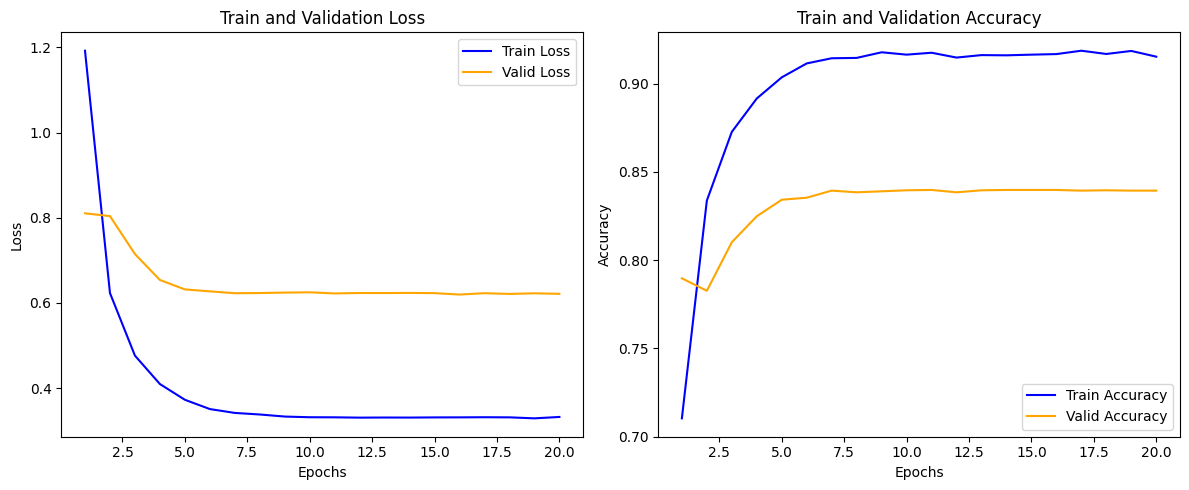

In [ ]:
trainer.plot_metrics()

После 6-7 эпохи модель просто перестала учиться. Попробую увеличить число обучаемых параметров + попробую новую архитектуру.

Предположение, что надо идти вглубь, пока что оказывается венрным, тк densenet имеет меньше обучаемых параметров, чем resnet18, однако архитектура более удачная видимо, раз обучилось лучше

In [ ]:
model_densenet = trainer.model
torch.save(model_densenet.state_dict(), 'model_densenet')

In [33]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
imgs = [val_dataset[id][0].unsqueeze(0) for id in range(len(val_dataset))]

In [ ]:
probs = predict(model_densenet, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs,-1)

actual_labels = [val_dataset[id][1] for id in range(len(val_dataset))]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [ ]:
from sklearn.metrics import f1_score
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-score:", f1)

F1-score: 0.8395108903324418


#### GoogLeNet

Обучаем до inception4c слоя. Все, что глуюже замораживаем

In [21]:
model_google = models.googlenet(weights=models.GoogLeNet_Weights.IMAGENET1K_V1)

In [22]:
model_google

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [23]:
for name, child in model_google.named_children():
    print(name)

conv1
maxpool1
conv2
conv3
maxpool2
inception3a
inception3b
maxpool3
inception4a
inception4b
inception4c
inception4d
inception4e
maxpool4
inception5a
inception5b
avgpool
dropout
fc


In [ ]:
flag = False
for name, child in list(model_google.named_children())[::-1]:
    if name == 'inception4c': flag = True  # обучаем до inception4c слоя. Все, что глуюже замораживаем

    if flag:
        for param in child.parameters():
            param.requires_grad = False

In [25]:
in_features=1024
out_features = n_classes

model_google.fc = nn.Linear(in_features, out_features)

params_to_optimize = filter(lambda p: p.requires_grad, model_google.parameters())
optimizer = torch.optim.Adam(params_to_optimize, lr=4e-3)

In [26]:
from torchsummary import summary
summary(model_google.cuda(), (3, 224, 224)).to_readable

Layer (type:depth-idx)                   Output Shape              Param #
├─BasicConv2d: 1-1                       [-1, 64, 112, 112]        --
|    └─Conv2d: 2-1                       [-1, 64, 112, 112]        (9,408)
|    └─BatchNorm2d: 2-2                  [-1, 64, 112, 112]        (128)
├─MaxPool2d: 1-2                         [-1, 64, 56, 56]          --
├─BasicConv2d: 1-3                       [-1, 64, 56, 56]          --
|    └─Conv2d: 2-3                       [-1, 64, 56, 56]          (4,096)
|    └─BatchNorm2d: 2-4                  [-1, 64, 56, 56]          (128)
├─BasicConv2d: 1-4                       [-1, 192, 56, 56]         --
|    └─Conv2d: 2-5                       [-1, 192, 56, 56]         (110,592)
|    └─BatchNorm2d: 2-6                  [-1, 192, 56, 56]         (384)
├─MaxPool2d: 1-5                         [-1, 192, 28, 28]         --
├─Inception: 1-6                         [-1, 256, 28, 28]         --
|    └─BasicConv2d: 2-7                  [-1, 64, 28, 28]  

<function torchsummary.model_statistics.ModelStatistics.to_readable(num: int) -> float>

In [27]:
import sys
sys.path.append('C:\projects\Python')

from torchlab.training import Trainer

In [31]:
trainer = Trainer(
    model = model_google.to(DEVICE),
    criterion = nn.CrossEntropyLoss(),
    optimizer = optimizer,
    device = DEVICE,
    train_loader = train_loader,
    test_loader = val_loader,
    epochs = 30,
    patience=4,
    scheduler=optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.65)
)

In [25]:
trainer.train_model()

Epoch 1/30 - Train Loss: 1.1467, Train Accuracy: 0.7098, Valid Loss: 0.9100, Valid Accuracy: 0.7581 - Time: 238.90s


Epoch 2/30 - Train Loss: 0.5334, Train Accuracy: 0.8544, Valid Loss: 0.6446, Valid Accuracy: 0.8313 - Time: 165.86s


Epoch 3/30 - Train Loss: 0.3623, Train Accuracy: 0.9002, Valid Loss: 0.4584, Valid Accuracy: 0.8819 - Time: 171.10s


Epoch 4/30 - Train Loss: 0.2743, Train Accuracy: 0.9254, Valid Loss: 0.3823, Valid Accuracy: 0.9018 - Time: 164.53s


Epoch 5/30 - Train Loss: 0.2108, Train Accuracy: 0.9415, Valid Loss: 0.3373, Valid Accuracy: 0.9138 - Time: 146.56s


Epoch 6/30 - Train Loss: 0.1666, Train Accuracy: 0.9536, Valid Loss: 0.3092, Valid Accuracy: 0.9222 - Time: 147.43s


Epoch 7/30 - Train Loss: 0.1333, Train Accuracy: 0.9626, Valid Loss: 0.3051, Valid Accuracy: 0.9215 - Time: 146.32s


Epoch 8/30 - Train Loss: 0.1191, Train Accuracy: 0.9662, Valid Loss: 0.2941, Valid Accuracy: 0.9293 - Time: 146.23s


Epoch 9/30 - Train Loss: 0.1048, Train Accuracy: 0.9693, Valid Loss: 0.2925, Valid Accuracy: 0.9276 - Time: 445.12s


Epoch 10/30 - Train Loss: 0.1015, Train Accuracy: 0.9715, Valid Loss: 0.2824, Valid Accuracy: 0.9301 - Time: 172.65s


Epoch 11/30 - Train Loss: 0.0900, Train Accuracy: 0.9755, Valid Loss: 0.2988, Valid Accuracy: 0.9322 - Time: 170.96s


Epoch 12/30 - Train Loss: 0.0950, Train Accuracy: 0.9738, Valid Loss: 0.2919, Valid Accuracy: 0.9299 - Time: 170.31s


Epoch 13/30 - Train Loss: 0.0848, Train Accuracy: 0.9753, Valid Loss: 0.2947, Valid Accuracy: 0.9322 - Time: 170.20s



Early stopping triggered after 13 epochs


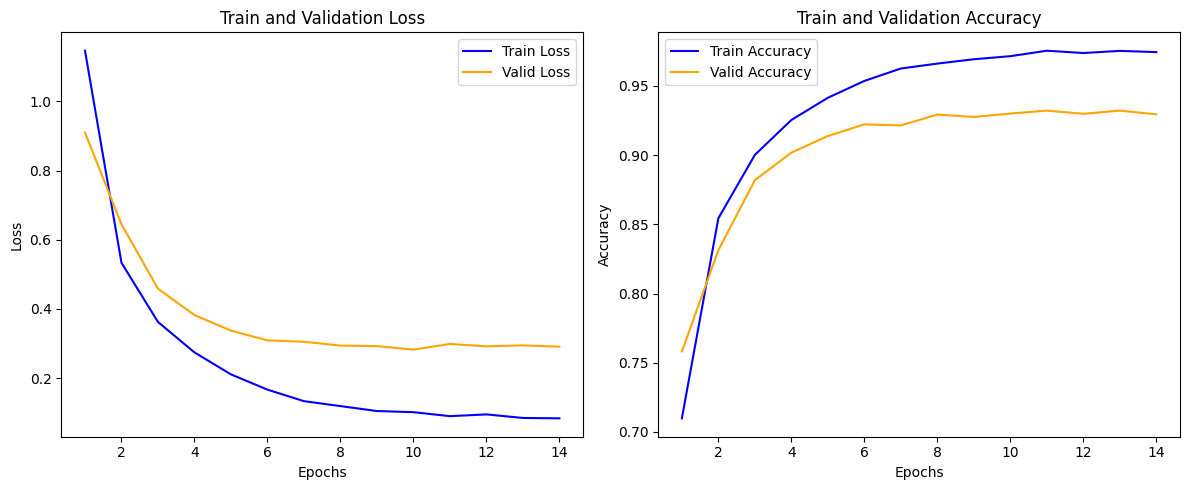

In [26]:
trainer.plot_metrics()

In [27]:
model_google = trainer.model
torch.save(model_google.state_dict(), 'model_google')

In [29]:
imgs = [val_dataset[id][0].unsqueeze(0) for id in range(len(val_dataset))]

In [31]:
probs = predict(model_google, imgs)

In [32]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [33]:
y_pred = np.argmax(probs,-1)

actual_labels = [val_dataset[id][1] for id in range(len(val_dataset))]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [34]:
from sklearn.metrics import f1_score
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-score:", f1)

F1-score: 0.930645777607948


Уже лучше, но все же хотелось бы еще больше скор

#### WideResNet101

Идем по крупному, очень глуюокая нейронка. Осталось только выбрать параметры для обучения

In [15]:
model_wideResNet101 = models.wide_resnet101_2(weights=models.Wide_ResNet101_2_Weights.IMAGENET1K_V2)

In [16]:
model_wideResNet101

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

In [17]:
for name, child in model_wideResNet101.named_children():
    print(name)

conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


In [ ]:
flag = False
for name, child in list(model_wideResNet101.named_children())[::-1]:
    if name == 'layer3': flag = True  # буду обучать все, что до этого слоя. Глубже - замораживаем

    if flag:
        for param in child.parameters():
            param.requires_grad = False

In [23]:
in_features = 2048
out_features = n_classes

model_wideResNet101.fc = nn.Linear(in_features, out_features)

params_to_optimize = filter(lambda p: p.requires_grad, model_wideResNet101.parameters())
optimizer = torch.optim.Adam(params_to_optimize, lr=4e-3)

In [24]:
from torchsummary import summary

summary(model_wideResNet101.cuda(), (3, 224, 224)).to_readable

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        (128)
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 256, 56, 56]         --
|    └─Bottleneck: 2-1                   [-1, 256, 56, 56]         --
|    |    └─Conv2d: 3-1                  [-1, 128, 56, 56]         (8,192)
|    |    └─BatchNorm2d: 3-2             [-1, 128, 56, 56]         (256)
|    |    └─ReLU: 3-3                    [-1, 128, 56, 56]         --
|    |    └─Conv2d: 3-4                  [-1, 128, 56, 56]         (147,456)
|    |    └─BatchNorm2d: 3-5             [-1, 128, 56, 56]         (256)
|    |    └─ReLU: 3-6                    [-1, 128, 56, 56]         --
|    |    └─Conv2d: 3-7                  [-1, 256, 56, 56] 

<function torchsummary.model_statistics.ModelStatistics.to_readable(num: int) -> float>

In [25]:
import sys
sys.path.append('C:\projects\Python')

from torchlab.training import Trainer

In [27]:
trainer = Trainer(
    model = model_wideResNet101.to(DEVICE),
    criterion = nn.CrossEntropyLoss(),
    optimizer = optimizer,
    device = DEVICE,
    train_loader = train_loader,
    test_loader = val_loader,
    epochs = 100,
    patience=5,
    scheduler=optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.72)
)

In [28]:
trainer.train_model()

Epoch 1/100 - Train Loss: 0.6612, Train Accuracy: 0.8446, Valid Loss: 0.3402, Valid Accuracy: 0.9156 - Time: 284.38s


Epoch 2/100 - Train Loss: 0.1952, Train Accuracy: 0.9517, Valid Loss: 0.2032, Valid Accuracy: 0.9486 - Time: 276.36s


Epoch 3/100 - Train Loss: 0.1094, Train Accuracy: 0.9729, Valid Loss: 0.1821, Valid Accuracy: 0.9566 - Time: 267.79s


Epoch 4/100 - Train Loss: 0.0655, Train Accuracy: 0.9832, Valid Loss: 0.1564, Valid Accuracy: 0.9622 - Time: 268.74s


Epoch 5/100 - Train Loss: 0.0375, Train Accuracy: 0.9901, Valid Loss: 0.1462, Valid Accuracy: 0.9656 - Time: 267.76s


Epoch 6/100 - Train Loss: 0.0253, Train Accuracy: 0.9931, Valid Loss: 0.1356, Valid Accuracy: 0.9715 - Time: 267.87s


Epoch 7/100 - Train Loss: 0.0176, Train Accuracy: 0.9957, Valid Loss: 0.1404, Valid Accuracy: 0.9698 - Time: 268.26s


Epoch 8/100 - Train Loss: 0.0117, Train Accuracy: 0.9971, Valid Loss: 0.1268, Valid Accuracy: 0.9719 - Time: 267.81s


Epoch 9/100 - Train Loss: 0.0112, Train Accuracy: 0.9970, Valid Loss: 0.1328, Valid Accuracy: 0.9721 - Time: 269.64s


Epoch 10/100 - Train Loss: 0.0086, Train Accuracy: 0.9978, Valid Loss: 0.1297, Valid Accuracy: 0.9734 - Time: 268.70s


Epoch 11/100 - Train Loss: 0.0077, Train Accuracy: 0.9984, Valid Loss: 0.1256, Valid Accuracy: 0.9715 - Time: 277.40s


Epoch 12/100 - Train Loss: 0.0074, Train Accuracy: 0.9978, Valid Loss: 0.1282, Valid Accuracy: 0.9690 - Time: 280.18s


Epoch 13/100 - Train Loss: 0.0065, Train Accuracy: 0.9987, Valid Loss: 0.1375, Valid Accuracy: 0.9738 - Time: 270.31s


Epoch 14/100 - Train Loss: 0.0072, Train Accuracy: 0.9975, Valid Loss: 0.1286, Valid Accuracy: 0.9744 - Time: 273.75s


Epoch 15/100 - Train Loss: 0.0058, Train Accuracy: 0.9987, Valid Loss: 0.1286, Valid Accuracy: 0.9721 - Time: 277.22s



Early stopping triggered after 15 epochs


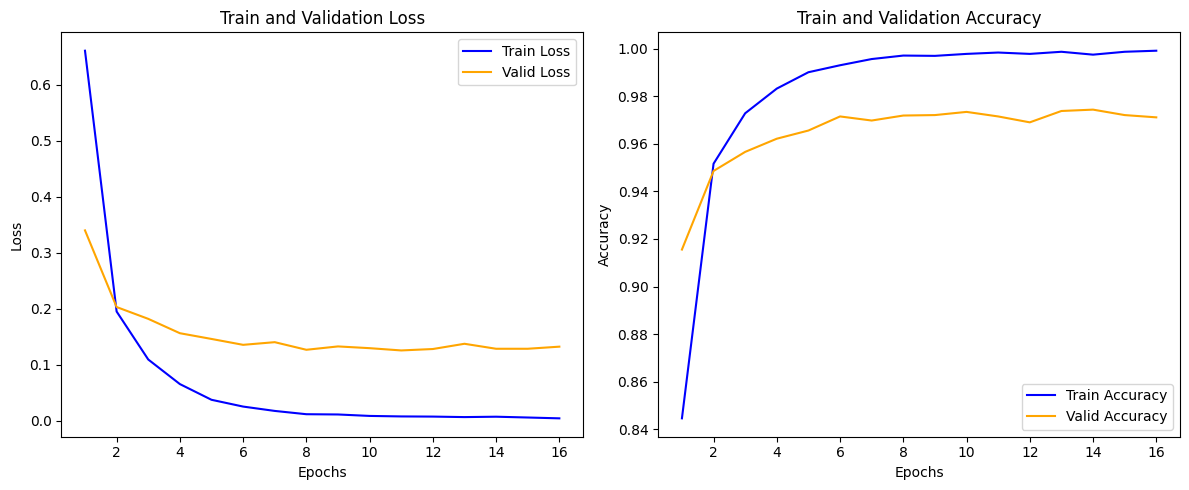

In [30]:
trainer.plot_metrics()

In [31]:
model_wideResNet101 = trainer.model
torch.save(model_wideResNet101.state_dict(), 'model_wideResNet101')

In [35]:
imgs = [val_dataset[id][0].unsqueeze(0) for id in range(len(val_dataset))]

In [36]:
probs = predict(model_wideResNet101, imgs)

In [37]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [38]:
y_pred = np.argmax(probs,-1)

actual_labels = [val_dataset[id][1] for id in range(len(val_dataset))]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [39]:
from sklearn.metrics import f1_score
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-score:", f1)

F1-score: 0.9747802827665265


Вот это уже другое дело, самбитим результат на kaggle

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит.
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [43]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [58]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [59]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [60]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [61]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [62]:
from sklearn.metrics import f1_score
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-оценка:", f1)


F1-оценка: 0.75


Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

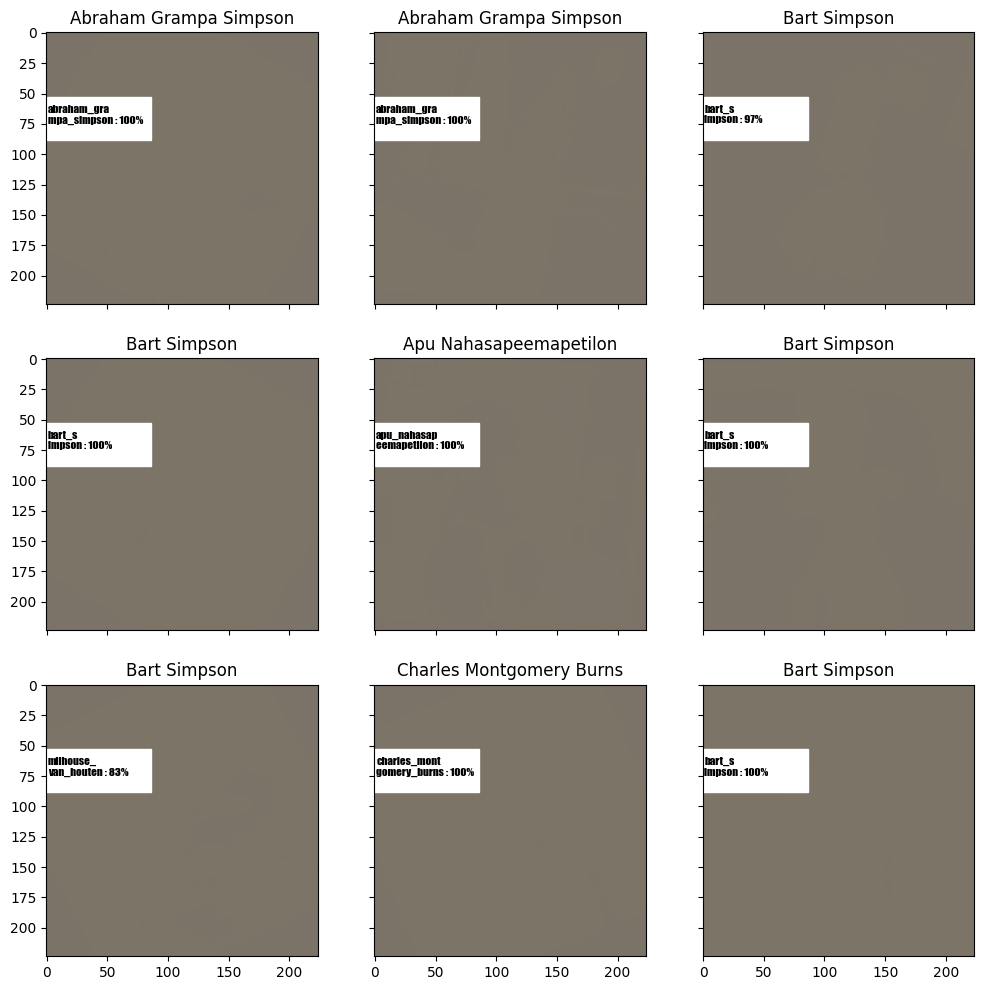

In [45]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model_wideResNet101, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [46]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model_wideResNet101, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
! ls

characters_illustration.png  label_encoder.pkl	sample_submission.csv  train
gdrive			     sample_data	testset


In [51]:
import pandas as pd
my_submit = pd.read_csv("C:\projects\Python\dl\DataBases\SIMPSONS\sample_submission.csv",index_col='Id')
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [53]:
my_submit.to_csv('model_wideResNet101_baseline.csv', index=False)

## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать.

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову:


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)
